In [1]:

import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# from mpl_toolkits.basemap import Basemap
import glob
from netCDF4 import Dataset
import copy
import gc
import os

import sys
# sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import grid_set as gs

import ant_plus
from imp import reload
reload(ant_plus)
reload(gs)

<module 'grid_set' from '/Users/h/PREMELT/Ant+/grid_set.py'>

In [2]:
file = 'Example_Merge/L2_ice_leads_West_Weddell_2019-09-01T06-52_2019-09-30T16-53.nc'
track=ant_plus.CS2_track(file,add_attr=True)
track.print_time()
fig_dir = file.split('.nc')[0]+'/'
check_dir = os.path.dirname(fig_dir)
if not os.path.exists(check_dir):
    os.makedirs(check_dir)

2019-09-01T06:52:56.312535--2019-09-30T16:53:21.795921


In [5]:
lon_r = np.min(track.lon_20_ku),np.max(track.lon_20_ku)
lat_r = np.min(track.lat_20_ku),np.max(track.lat_20_ku)
lon_r,lat_r

((-57.9164476, -40.000136999999995), (-75.51515979999999, -63.000023299999995))

In [6]:
track.list_vars(['ANOM','flag','interp'])

['ocean_tide_20_ku_ANOM_DTU_fes',
 'range_1_20_ku_ANOM_ISat_2step',
 'range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice',
 'range_1_20_ku_ANOM_DTU_imp_th70',
 'range_1_20_ku_ANOM_DTU_th70',
 'range_1_20_ku_ANOM_DTU_gauss',
 'range_1_20_ku_ANOM_MSSL_D',
 'range_1_20_ku_ANOM_MSSL_S',
 'range_1_20_ku_ANOM_LEGOS_GPOD_All',
 'range_1_20_ku_ANOM_CLS',
 'mean_sea_surf_20_ku_ANOM_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU21',
 'atm_geo_corrections_sum_ANOM_ISat',
 'atm_geo_corrections_sum_ANOM_LEGOS_GPOD',
 'ssha_interp_20_ku',
 'ssha_interp_20_ku_LEGOS_GPOD_Ice',
 'ssha_interp_20_ku_LEGOS_GPOD_Lead',
 'ssha_interp_20_ku_ANOM_LEGOS_GPOD',
 'ssha_interp_20_ku_ANOM_LEGOS_GPOD',
 'flag_surf_type_class_20_ku',
 'flag_surf_type_20_ku_CLS',
 'flag_surf_type_20_ku_LEGOS_GPOD']

In [7]:
load_list = track.list_vars(['ANOM','flag','interp','height','geoid','ssha'])
track.add_vars(load_list)

Got a grid res =  36  x  54
Note that all grid info is in nx x ny grids, whilst data is in nx x ny


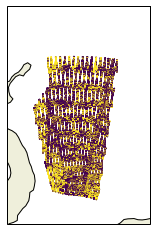

In [8]:
#$### map projection
m = ccrs.Orthographic(np.mean(lon_r),np.mean(lat_r))
proj_cart = ccrs.PlateCarree() 
f = plt.figure()
G= gs.grid_set(m)

lat_shift= 3 ### add to top lat to fix curvature on map edges
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([lon_r[0]-2, lon_r[1]+4, lat_r[0]-2, lat_r[1]+2+lat_shift])#, ccrs.PlateCarree())
G.set_grid_dxy(40e3,40e3,ax)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
# plt.close()
x,y = G.mplot(track.lon_20_ku,track.lat_20_ku)
ax.scatter(x,y,s=0.1,c=track.flag_surf_type_class_20_ku)


In [94]:
track.mean_sea_surf_20_ku_ANOM_DTU15_attr


{'Description': 'Anomaly from L2 MSS to _DTU15 MSS',
 'coordinates': 'lon_poca_20_ku lat_poca_20_ku',
 'Units': 'm'}

In [95]:
p_vars

['atm_geo_corrections_sum_ANOM_ISat',
 'atm_geo_corrections_sum_ANOM_LEGOS_GPOD',
 'default_L2']

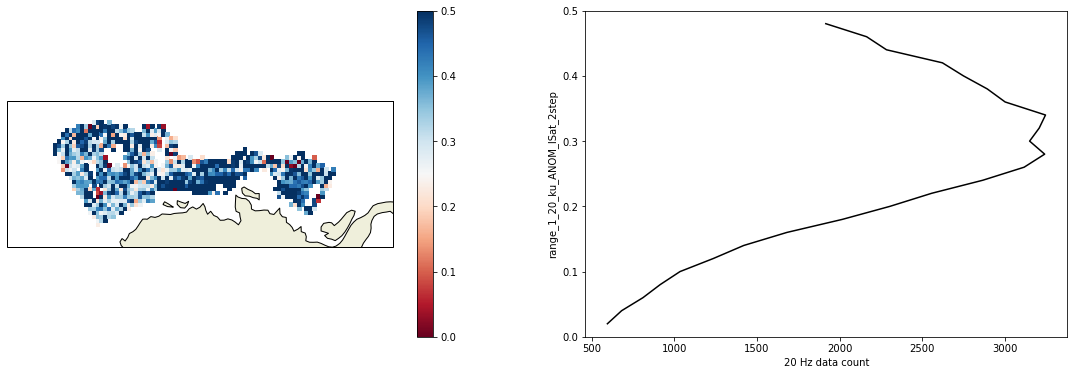

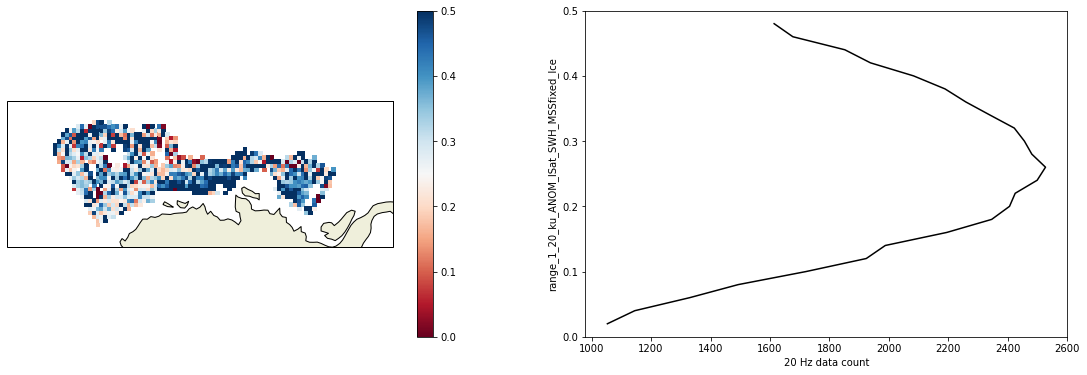

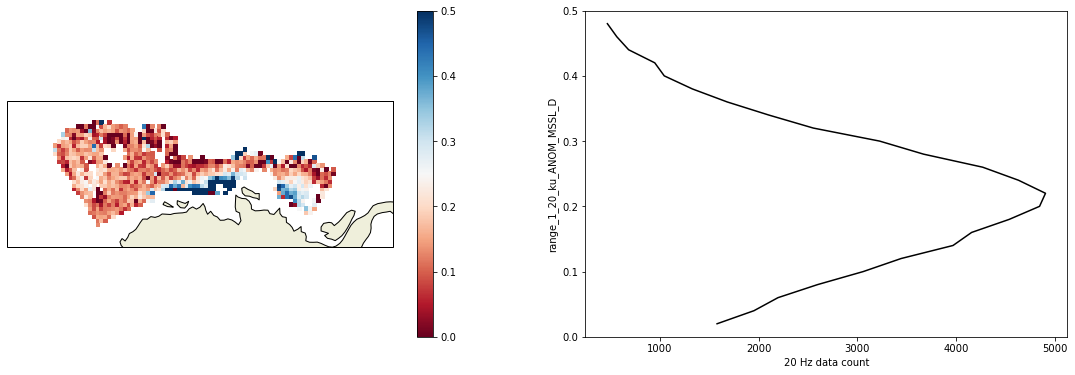

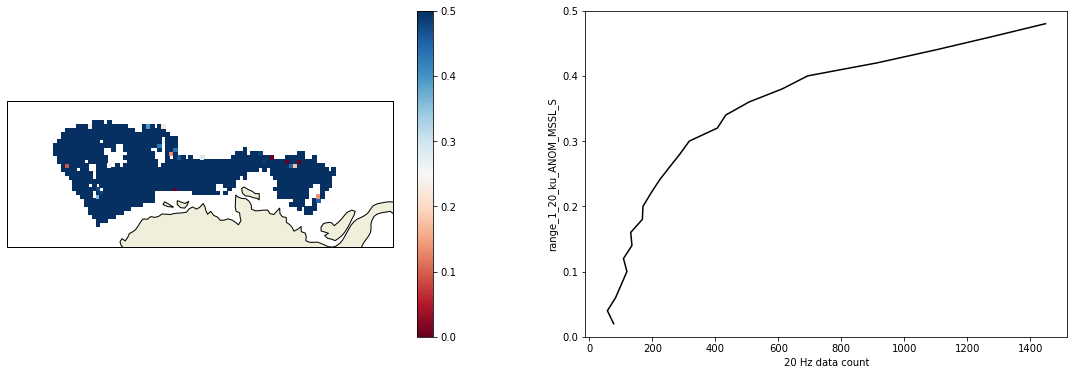

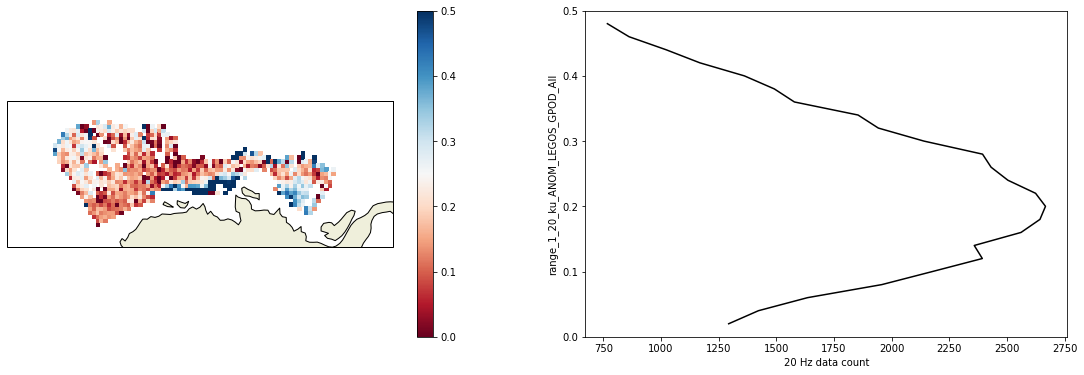

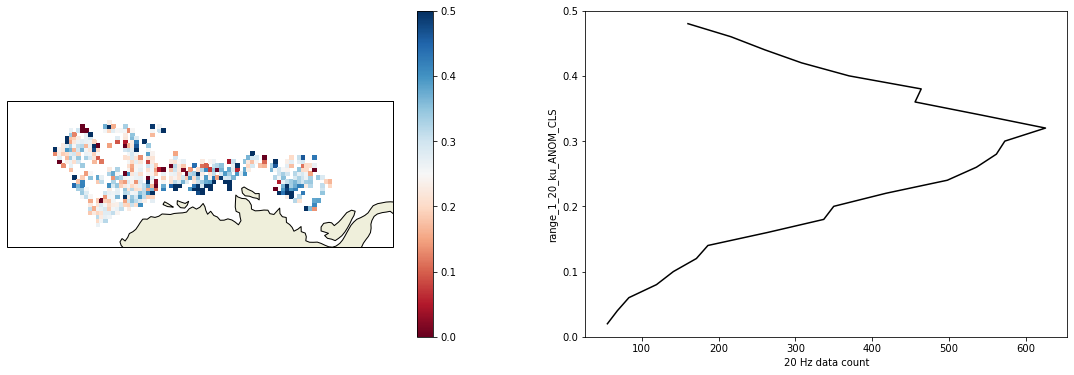

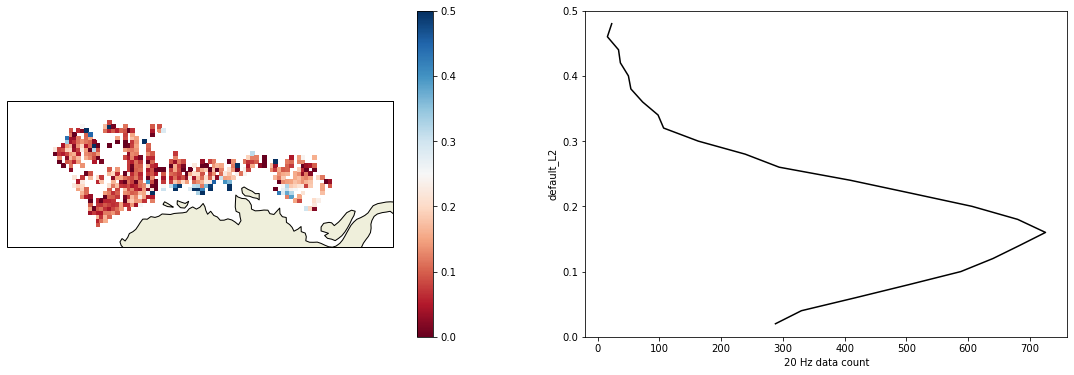

In [108]:
### Leads
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'CLS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'interp' in p]
# p_vars = [p for p in track.vars if 'mean_sea' in p]
# p_vars = [p for p in track.vars if 'range' in p and 'ANOM' in p]
p_vars = [p for p in track.vars if 'range' in p and 'DTU' not in p] # no sea ice in DTU
# p_vars = [p for p in track.vars if 'ANOM' in p and 'atm' in p] # no sea ice in DTU
p_vars = p_vars+['default_L2']
SaveT = 'Freeboard_'
h_auto = False
h_sym = False
h_trim = False ### centiles to knock off
h_min = -0.4
h_max =  0.4
h_min = -0.0
h_max =  0.5
hard_min = -10.0
hard_max =  10.0
LG_CLS_flag = 2 # 1 ocean, 2 ice, 3 lead
h_bins = np.arange(h_min,h_max,0.02)
msk = track.flag_surf_type_class_20_ku ==  128
# msk[track.flag_surf_type_class_20_ku ==  64] = True
for v in p_vars:
#     x = getattr(track,v).copy()
    if 'default' in v: 
#         x = track.height_1_20_ku - track.geoid_20_ku #### to make DOT
        x = track.ssha_20_ku - track.ssha_interp_20_ku #### to make FB
    else:
        x = getattr(track,v).copy()
#         x = x + track.height_1_20_ku - track.geoid_20_ku #### to make DOT
        x = x + track.ssha_20_ku - track.ssha_interp_20_ku #### to make FB
    if 'GPOD' in v:
        msk[track.flag_surf_type_20_ku_LEGOS_GPOD!=LG_CLS_flag] = 0
    if 'CLS' in v:
        msk[track.flag_surf_type_20_ku_CLS!=LG_CLS_flag] = 0
#     if 'class' in v:
#         x[x<64] = 0
#         x[x==256] = 3
#         x[x==128] = 2
#         x[x==64] = 1
    x[x.mask] = np.nan
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    x = x[msk]
    if h_trim:
        h_t0,h_t1 = np.nanpercentile(x[msk],[h_trim,100-h_trim])
        msk[x>h_t1] = 0
        msk[x<h_t0] = 0
    if h_auto:
        h_min,h_max = np.nanpercentile(x,[0.5,99.5])
        if h_sym:
            h_max = np.maximum(np.abs(h_min),np.abs(h_max))
            h_min = -h_max
        h_bins = np.arange(h_min,h_max,(h_max-h_min)/50)
    
    
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0)
#                              bin_func = func_u)

    f = plt.figure(figsize=[19,6])
    ax = f.add_subplot(1,2,1,projection=m)
#     ax.set_extent([-180, 180, -90, -50], proj_cart)
    ax.set_extent([lon_r[0]-2, lon_r[1]+2, lat_r[0]-2, lat_r[1]+2+lat_shift])#, ccrs.PlateCarree())
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=1.0,pad=0.05)
    
    ax = f.add_subplot(1,2,2)
    hist = np.histogram(x,bins=h_bins)[0]
    ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
    ax.set_ylim([h_min,h_max])
    ax.set_ylabel(v)
    ax.set_xlabel('20 Hz data count')
    f.savefig(fig_dir+'Leads_'+SaveT+v+'_map_hist.png',bbox_inches='tight')

    plt.show()

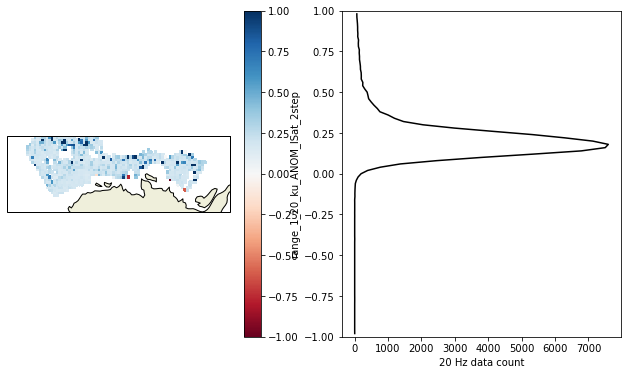

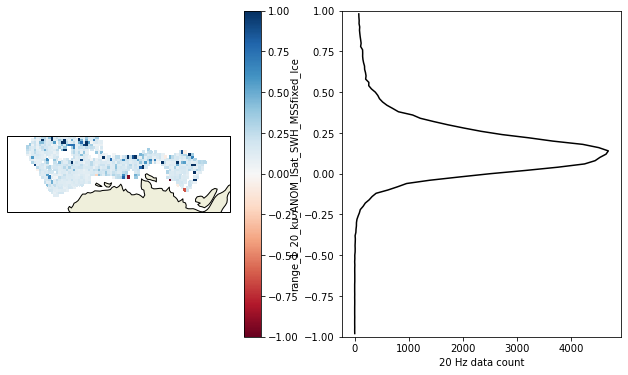

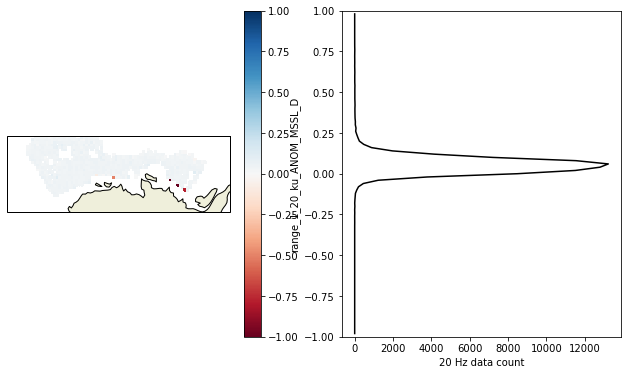

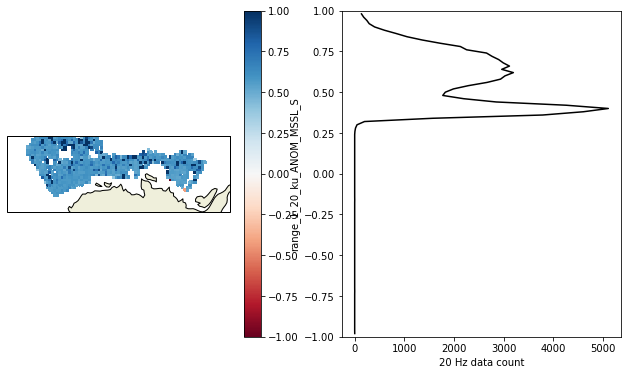

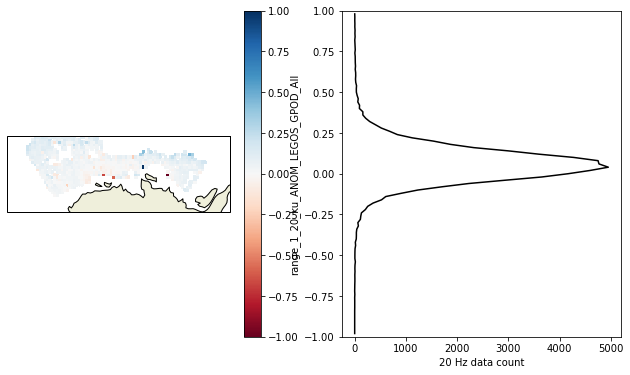

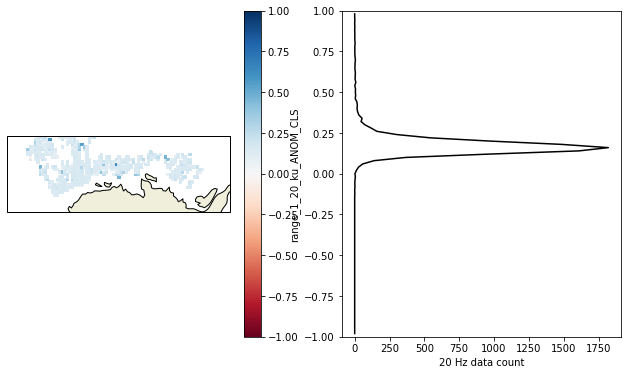

In [100]:
### Ice
from scipy.stats import trim_mean
def func_u(x):
    return trim_mean(x,0.1)
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'CLS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'interp' in p]
# p_vars = [p for p in track.vars if 'mean_sea' in p]
p_vars = [p for p in track.vars if 'range' in p and 'ANOM' in p]
# p_vars = [p for p in track.vars if 'range' in p and 'DTU' not in p] # no sea ice in DTU
##### No DTU over Ice
p_vars = [p for p in p_vars if 'DTU' not in p]
h_auto = False
h_min = -1.0
h_max =  1.0
hard_min = -10.0
hard_max =  10.0
LG_CLS_flag = 2 # 1 ocean, 2 ice, 3 lead
h_bins = np.arange(h_min,h_max,0.02)
msk = track.flag_surf_type_class_20_ku ==  128
for v in p_vars:
    x = getattr(track,v).copy()
    if 'GPOD' in v:
        msk[track.flag_surf_type_20_ku_LEGOS_GPOD!=LG_CLS_flag] = 0
    if 'CLS' in v:
        msk[track.flag_surf_type_20_ku_CLS!=LG_CLS_flag] = 0
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    x = x[msk]
    if h_auto:
        h_min,h_max = np.nanpercentile(x,[0.5,99.5])
        h_bins = np.arange(h_min,h_max,(h_max-h_min)/50)
    
    
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0,
                             bin_func = func_u)

    f = plt.figure(figsize=[11,6])
    ax = f.add_subplot(1,2,1,projection=m)
#     ax.set_extent([-180, 180, -90, -50], proj_cart)
    ax.set_extent([lon_r[0]-2, lon_r[1]+2, lat_r[0]-2, lat_r[1]+2])#, ccrs.PlateCarree())
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=1.0,pad=0.05)
    
    ax = f.add_subplot(1,2,2)
    hist = np.histogram(x,bins=h_bins)[0]
    ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
    ax.set_ylim([h_min,h_max])
    ax.set_ylabel(v)
    ax.set_xlabel('20 Hz data count')
    f.savefig(fig_dir+'Ice_'+v+'_map_hist.png',bbox_inches='tight')

    plt.show()

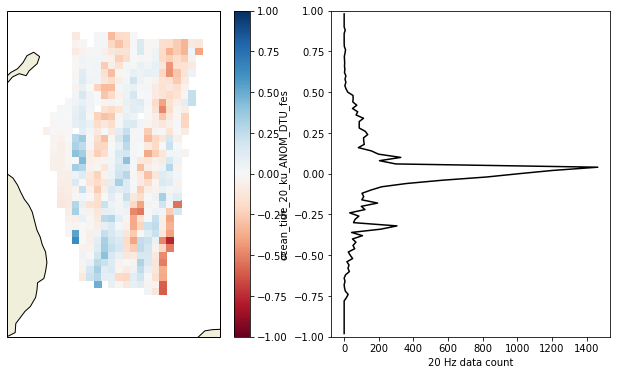

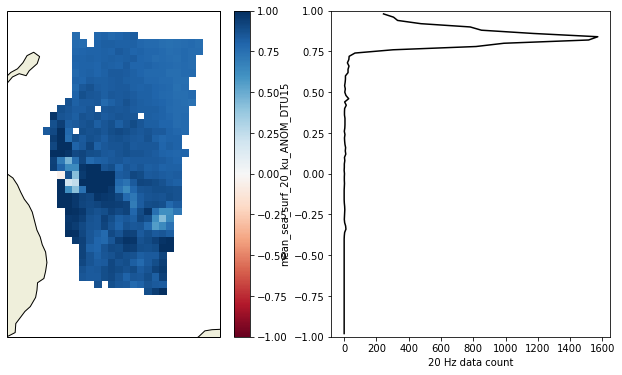

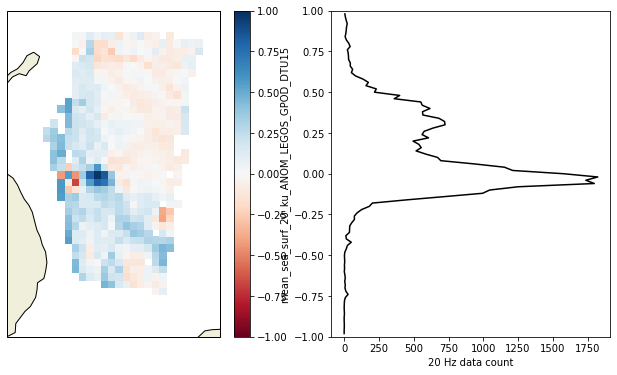

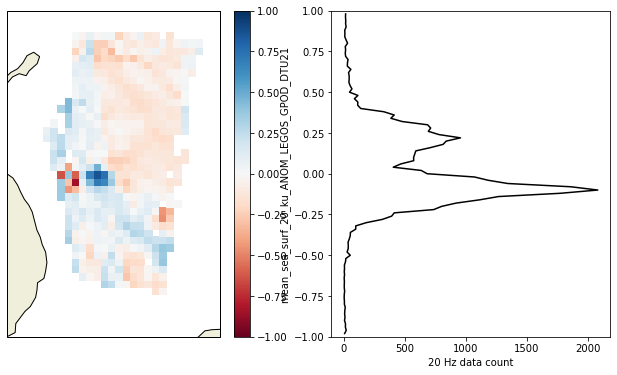

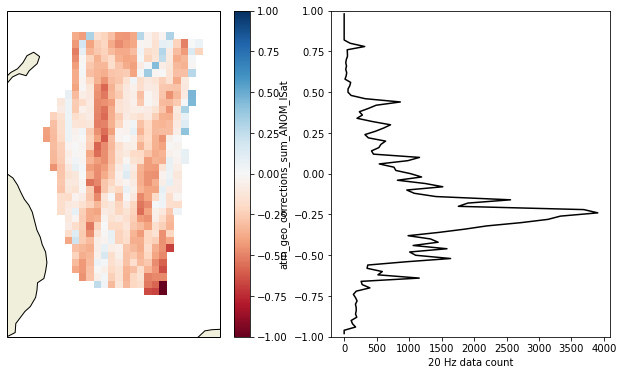

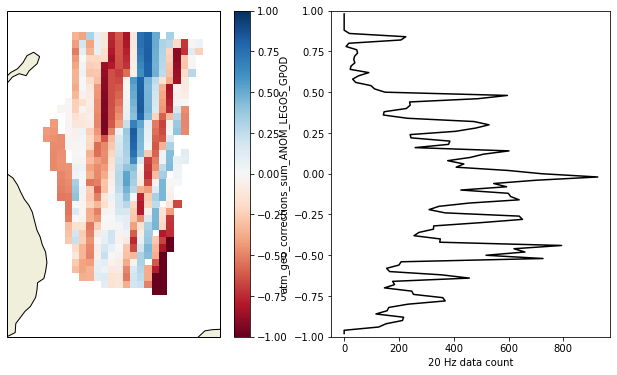

In [58]:
### All
from scipy.stats import trim_mean
def func_u(x):
    return trim_mean(x,0.1)
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'CLS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'interp' in p]
p_vars = [p for p in track.vars if 'mean_sea' in p]
p_vars = [p for p in track.vars if 'ANOM' in p and 'range' not in p]
# p_vars = [p for p in track.vars if 'range' in p and 'DTU' not in p] # no sea ice in DTU
##### No DTU over Ice
# p_vars = [p for p in p_vars if 'DTU' not in p]
h_auto = False
h_min = -1.0
h_max =  1.0
hard_min = -10.0
hard_max =  10.0
LG_CLS_flag = 2 # 1 ocean, 2 ice, 3 lead
h_bins = np.arange(h_min,h_max,0.02)
msk = track.flag_surf_type_class_20_ku >=  128
for v in p_vars:
    x = getattr(track,v).copy()
    if 'GPOD' in v:
        msk[track.flag_surf_type_20_ku_LEGOS_GPOD>=LG_CLS_flag] = 0
    if 'CLS' in v:
        msk[track.flag_surf_type_20_ku_CLS>=LG_CLS_flag] = 0
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    x = x[msk]
    if h_auto:
        h_min,h_max = np.nanpercentile(x,[0.5,99.5])
        h_bins = np.arange(h_min,h_max,(h_max-h_min)/50)
    
    
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0,
                             bin_func = func_u)

    f = plt.figure(figsize=[11,6])
    ax = f.add_subplot(1,2,1,projection=m)
#     ax.set_extent([-180, 180, -90, -50], proj_cart)
    ax.set_extent([lon_r[0]-2, lon_r[1]+2, lat_r[0]-2, lat_r[1]+2])#, ccrs.PlateCarree())
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    cax = plt.colorbar(s,shrink=1.0,pad=0.05)
    
    ax = f.add_subplot(1,2,2)
    hist = np.histogram(x,bins=h_bins)[0]
    ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
    ax.set_ylim([h_min,h_max])
    ax.set_ylabel(v)
    ax.set_xlabel('20 Hz data count')
    f.savefig(fig_dir+'All_'+v+'_map_hist.png',bbox_inches='tight')

    plt.show()

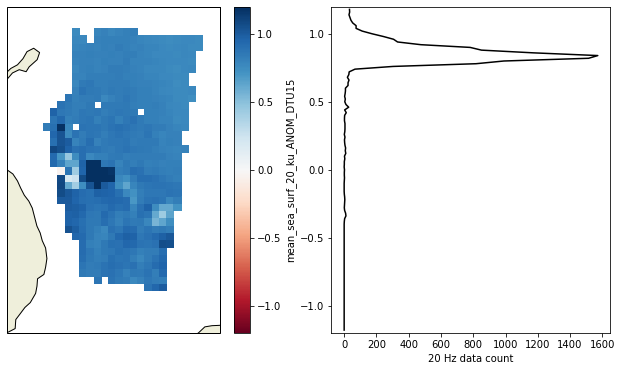

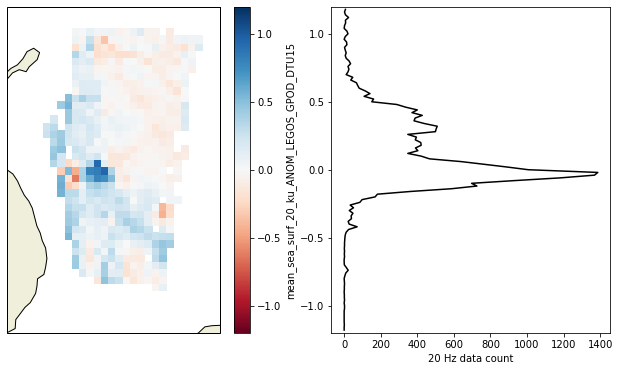

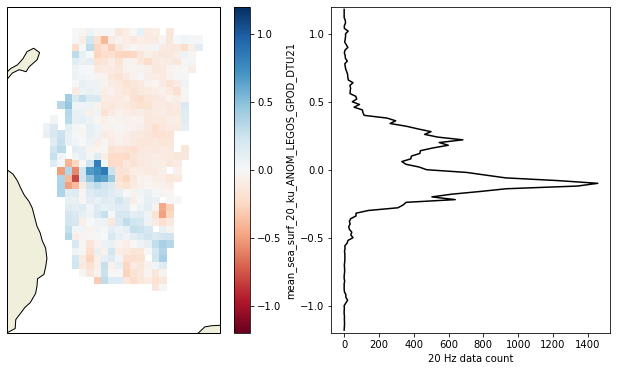

In [32]:
### Leads
from scipy.stats import trim_mean
def func_u(x):
    return trim_mean(x,0.1)
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'CLS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'interp' in p]
p_vars = [p for p in track.vars if 'mean_sea' in p]
# p_vars = [p for p in track.vars if 'range' in p]
# p_vars = [p for p in track.vars if 'range' in p and 'DTU' not in p] # no sea ice in DTU
h_min = -1.2
h_max =  1.2
hard_min = -10.0
hard_max =  10.0
LG_CLS_flag = 3 # 1 ocean, 2 ice, 3 lead
h_bins = np.arange(h_min,h_max,0.02)
msk = track.flag_surf_type_class_20_ku ==  256
for v in p_vars:
    x = getattr(track,v).copy()
#     if 'GPOD' in v:
#         msk[track.flag_surf_type_20_ku_LEGOS_GPOD!=LG_CLS_flag] = 0
    if 'CLS' in v:
        msk[track.flag_surf_type_20_ku_CLS!=LG_CLS_flag] = 0
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    x = x[msk]
    
    
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0,
                             bin_func = func_u)

    f = plt.figure(figsize=[11,6])
    ax = f.add_subplot(1,2,1,projection=m)
#     ax.set_extent([-180, 180, -90, -50], proj_cart)
    ax.set_extent([lon_r[0]-2, lon_r[1]+2, lat_r[0]-2, lat_r[1]+2])#, ccrs.PlateCarree())
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=1.0,pad=0.05)
    
    ax = f.add_subplot(1,2,2)
    hist = np.histogram(x,bins=h_bins)[0]
    ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
    ax.set_ylim([h_min,h_max])
    ax.set_ylabel(v)
    ax.set_xlabel('20 Hz data count')
    f.savefig(fig_dir+'Leads_'+v+'_map_hist.png',bbox_inches='tight')

    plt.show()

In [72]:
for v in track.vars:
#     if 'range' in v and 'ANOM' not in v:
#     if 'range' in v and 'ISat' in v:
    if 'ANOM' in v:
        print('-----')
        print(v)
        print('-----')
        if hasattr(track,v+'_attr'):
            attr = getattr(track,v+'_attr')
            for key, value in attr.items():
                print(key, ' : ', value)
        x = copy.copy(getattr(track,v))
        if type(x.mask) == np.ndarray:
            x[x.mask] = np.nan
        print('Distribution of '+v+' = '+' , '.join('{:.3}'.format(pc) for pc in np.nanpercentile(x,[25,50,75])))

-----
ocean_tide_20_ku_ANOM_DTU_fes
-----
Description  :  Anomaly from L2 ocean_tide_eq+ocean_tide to DTU_fes ocean tide
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of ocean_tide_20_ku_ANOM_DTU_fes = -0.0245 , -0.0108 , 0.00403
-----
range_1_20_ku_ANOM_ISat_2step
-----
Description  :  Anomaly from L2 range to _ISat_2step retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_ISat_2step = -0.0247 , 0.0083 , 0.0352
-----
range_1_20_ku_ANOM_DTU_imp_th70
-----
Description  :  Anomaly from L2 range to _DTU_imp_th70 retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_DTU_imp_th70 = -0.217 , -0.208 , -0.198
-----
range_1_20_ku_ANOM_DTU_th70
-----
Description  :  Anomaly from L2 range to _DTU_th70 retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_DTU_th70 = -0.194 , -0.175 , -0.16
-----
range_1_20_ku